# Scenario A - Noise Level Variation (individual dataset)

This file is used to zoom in and experiment on on a previously generated dataset.

The model used in the inference of the parameters is formulated as follows: 

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions

In [2]:
import os
import sys
sys.path.append('../../utils')
import utils as utl
import datagen as dg
import models as mdl
import results as res
import figures as fig

## Local settings

In [3]:
# dataset to load
ndata = '04'
input_datafile = './output/dataset_'+ str(ndata) + '.csv' 
input_peakfile = './output/peakinfo.csv' 

# output for results and images
out_path = './output_' + str(ndata) + '/'
fbase    = 'scenario_noise' + str(ndata)
file_basename = out_path + fbase

# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

# provide peak positions to the model as testvalues ('yes'/'no')
peak_info = 'yes'

# model mode ('train'/'eval')
model_mode = 'train'

# Load data and plot

In [4]:
ldata  = []
lpeaks = []
nsets  = 10
        
# load data from disk
print("loading file {0}".format(input_datafile))
df = pd.read_csv(input_datafile)
ldata.append(df)
print("loading peakinfo {0}".format(input_peakfile))
pks = np.loadtxt(input_peakfile, delimiter=',')
lpeaks.append(pks[int(ndata)-1])

loading file ./output/dataset_04.csv
loading peakinfo ./output/peakinfo.csv


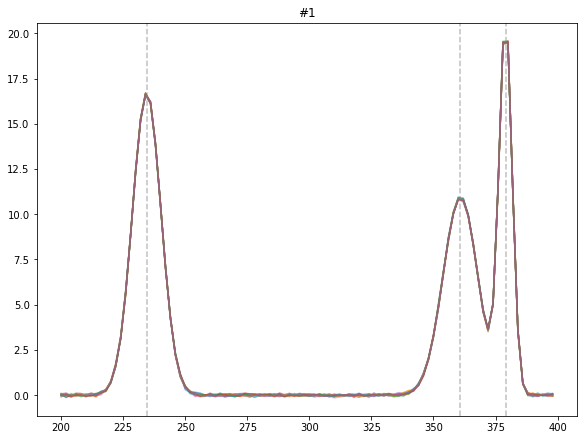

In [5]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(1,1), figure_size=(8,6), savefig='yes', fname=file_basename)

# Initialize models and run inference

In [6]:
# convert pandas data to numpy arrays
x_val = np.array(ldata[0].columns.to_list(), dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [7]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if peak_info == 'yes':
        plist = lpeaks[i].flatten()
        plist.sort()
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3, mu_peaks=plist)
    else:
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3)      
    models.append(model_g)
    
    with model_g:
        if model_mode == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            #trace_g = pm.sample(2000, init='adapt_diag')
            trace_g = pm.sample(2000)
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


running inference on dataset #1/1


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [06:42<00:00, 12.42draws/s] 
The acceptance probability does not match the target. It is 0.9654097443034342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9803966943881713, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


# Model visualization

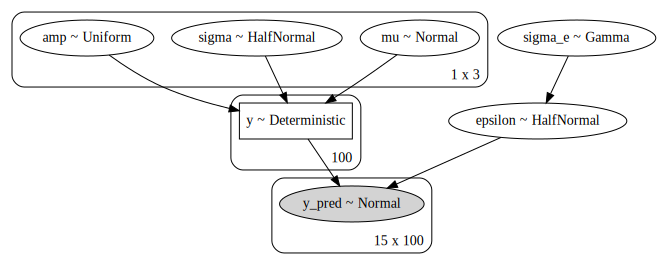

In [8]:
pm.model_to_graphviz(models[0])

In [9]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [10]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 420.68it/s]


In [11]:
# various plots to inspect the inference results
varnames = ['amp', 'mu', 'sigma', 'epsilon']

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

In [12]:
if model_mode == 'train':
    # collect the results and display
    df = res.get_results_summary(varnames, traces, ppc, y_val)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
df

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon
1,1.0,0.0,3466.5,1.043459,0.999299,-1873.504542,0.128433


In [13]:
if model_mode == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

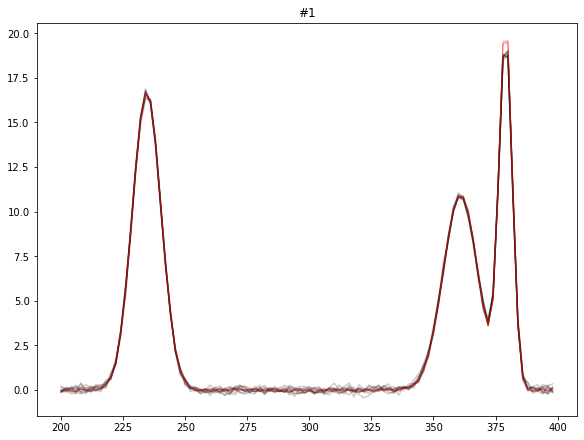

In [14]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(1,1), figure_size=(8,6), savefig='yes', 
                       fname=file_basename, showpeaks='no')

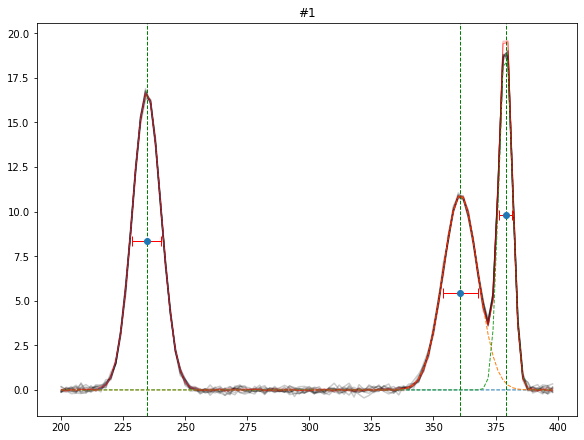

In [15]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(1,1), figure_size=(8,6), savefig='no', 
                       fname=file_basename, showpeaks='yes')